# 1. Import Libraries

In [ ]:
# import system libs
import os

# from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# import Deep learning Libraries and required compoenents
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# 2. Helper Functions


In [ ]:
def train_and_evaluate_model(model, train_gen, valid_gen, test_gen, augmentation_type, epochs=50):
    """
    Train model and visualize results for a specific augmentation strategy
    """
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        verbose=1
    )

    # plot and get metrics
    metrics = plot_training_history(history, augmentation_type)

    # get precision and recall
    predicted_classes, true_classes = get_predictions(model, test_gen)
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    metrics.update({
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1
    })

    return history, metrics


In [ ]:
def plot_training_history(history, augmentation_type):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch = {str(index_loss + 1)}'
    acc_label = f'best epoch = {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    metrics = {
        'best_val_loss': val_lowest,
        'best_val_loss_epoch': index_loss + 1,
        'best_val_acc': acc_highest,
        'best_val_acc_epoch': index_acc + 1
    }

    return metrics


In [ ]:
def get_predictions(model, generator):
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    return predicted_classes, true_classes

def evaluate_model(model, generator, class_names):
    predicted_classes, true_classes = get_predictions(model, generator)

    # get detailed metrics
    precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes)

    # print classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    return precision, recall, f1, support

In [ ]:
def confusion_matrix_plot(test_gen, y_predict):
  y_pred = np.argmax(y_predict, axis=1)

  # get class indices and labels
  class_indices = test_gen.class_indices
  classes = list(class_indices.keys())

  # compute confusion matrix
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  threshold = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(
          j, i, f"{cm[i, j]}",
          horizontalalignment='center',
          color='white' if cm[i, j] > threshold else 'black'
      )

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

# 3. Load Data

## 3.1 Loading from Kaggle

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.')


Data source import complete.


In [ ]:
print(andrewmvd_lung_and_colon_cancer_histopathological_images_path)

/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [ ]:
print(os.listdir(andrewmvd_lung_and_colon_cancer_histopathological_images_path))

['lung_colon_image_set']


## 3.2 Joining Images

In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set'

file_paths = []
labels = []

folders = os.listdir(data_dir)

for folder in folders:
    sub_folder_path = os.path.join(data_dir, folder)
    sub_folder = os.listdir(sub_folder_path)

    for sfolder in sub_folder:
        s_sub_folder_path = os.path.join(sub_folder_path, sfolder)
        file_list = os.listdir(s_sub_folder_path)

        for file in file_list:
            fpath = os.path.join(s_sub_folder_path, file)

            file_paths.append(fpath)
            labels.append(sfolder)


FSeries = pd.Series(file_paths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)

## 3.3 Split Data

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

# 4. Preprocessing

## 4.1 Helper Function

In [ ]:
# Function to create data generators for each augmentation pipeline
def create_data_generators(train_df, valid_df, test_df, augmentation_pipeline):
    train_generator = augmentation_pipeline.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    # Validation and test generators use only rescaling
    valid_test_generator = ImageDataGenerator(rescale=1./255)

    valid_generator = valid_test_generator.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = valid_test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator, test_generator

## 4.2 Data Augmentation

In [ ]:
# Define image size and batch size
IMG_SIZE = 128  # Standard size for many CNN architectures
BATCH_SIZE = 8

### 4.2.1 Basic Augmentation

In [ ]:
# Basic Augmentation Pipeline
# Focuses on basic geometric transformations
basic_augmentation = ImageDataGenerator(
    rescale=1./255
)

# Create generators for each augmentation pipeline
basic_train_gen, basic_valid_gen, basic_test_gen = create_data_generators(
    train_df, valid_df, test_df, basic_augmentation)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.2 Moderate Augmentation

In [ ]:
# Moderate Augmentation Pipeline
# Adds intensity transformations while preserving tissue characteristics
moderate_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

moderate_train_gen, moderate_valid_gen, moderate_test_gen = create_data_generators(
    train_df, valid_df, test_df, moderate_augmentation)


Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.3 Advanced Augmentation

In [ ]:
# Advanced Augmentation Pipeline
# Includes color transformations suitable for histopathology
advanced_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True
)

advanced_train_gen, advanced_valid_gen, advanced_test_gen = create_data_generators(
    train_df, valid_df, test_df, advanced_augmentation
)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


# 5. Model Initialization

## 5.1 Initialize CapsNet

In [ ]:
def squash(s, axis=-1):
  s_squared_norm = K.sum(K.square(s), axis, keepdims=True)
  scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
  return scale * s

In [ ]:
class CapsuleLayer(layers.Layer):
  def __init__(self, num_capsules, dim_capsule, num_routing=3, **kwargs):
    super(CapsuleLayer, self).__init__(**kwargs)
    self.num_capsules = num_capsules
    self.dim_capsule = dim_capsule
    self.num_routing = num_routing

  def build(self, input_shape):
    self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.dim_capsule],
                              initializer='glorot_uniform', trainable=True)

  def call(self, inputs):
    u_hat = K.dot(inputs, self.W)
    u_hat = K.reshape(u_hat, (-1, inputs.shape[1], self.num_capsules, self.dim_capsule))
    b = tf.zeros_like(u_hat[..., 0])

    for i in range(self.num_routing):
      c = tf.nn.softmax(b, axis=2)
      s = tf.reduce_sum(c[..., None] * u_hat, axis=1)
      v = squash(s)
      if i < self.num_routing - 1:
        b += tf.reduce_sum(u_hat * v[:, None, :, :], axis=-1)
    return v

 ## 5.2 CapsNet Model


In [ ]:
def create_model():
  img_size = (128, 128)
  channels = 3
  img_shape = (img_size[0], img_size[1], channels)
  class_count = len(list(basic_train_gen.class_indices.keys()))

  inputs = layers.Input(shape=img_shape)
  x = layers.Conv2D(64, (9, 9), strides=1, activation='relu', padding='same')(inputs)
  x = layers.Conv2D(128, (9, 9), strides=2, activation='relu', padding='same')(x)
  x = layers.Reshape((-1, 16))(x)
  x = layers.Lambda(squash)(x)
  primary_caps = CapsuleLayer(num_capsules=16, dim_capsule=8)(x)
  digit_caps = CapsuleLayer(num_capsules=class_count, dim_capsule=8)(primary_caps)
  outputs = layers.Lambda(lambda v: K.sqrt(K.sum(K.square(v), axis=2)))(digit_caps)

  model = models.Model(inputs, outputs)
  model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

## 5.2 Model Training

### 5.2.1 Training Basic Augmentation

In [ ]:
model_basic = create_model()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 32768, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_4 (Lambda)                    │ (None, 32768, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_layer_4 (CapsuleLayer)       │ (None, 16, 8)               │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_layer_5 (CapsuleLayer)       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_5 (Lambda)                    │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 681,664 (2.60 MB)

 Trainable params: 681,664 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 143s 61ms/step - accuracy: 0.5724 - loss: 0.9958 - val_accuracy: 0.8120 - val_loss: 0.4834
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 120s 55ms/step - accuracy: 0.8017 - loss: 0.4850 - val_accuracy: 0.8312 - val_loss: 0.4137
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 119s 54ms/step - accuracy: 0.8226 - loss: 0.4370 - val_accuracy: 0.8435 - val_loss: 0.3681
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 119s 54ms/step - accuracy: 0.8382 - loss: 0.3910 - val_accuracy: 0.8685 - val_loss: 0.3501
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 119s 54ms/step - accuracy: 0.8644 - loss: 0.3403 - val_accuracy: 0.8789 - val_loss: 0.2834
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 119s 54ms/step - accuracy: 0.8907 - loss: 0.2858 - val_accuracy: 0.8925 - val_loss: 0.2751
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 119s 54ms/step - accuracy: 0.9044 - loss: 0.2450 - val_accuracy: 0.8811 - val_loss: 0.2981
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 119s 54ms/step - accuracy: 

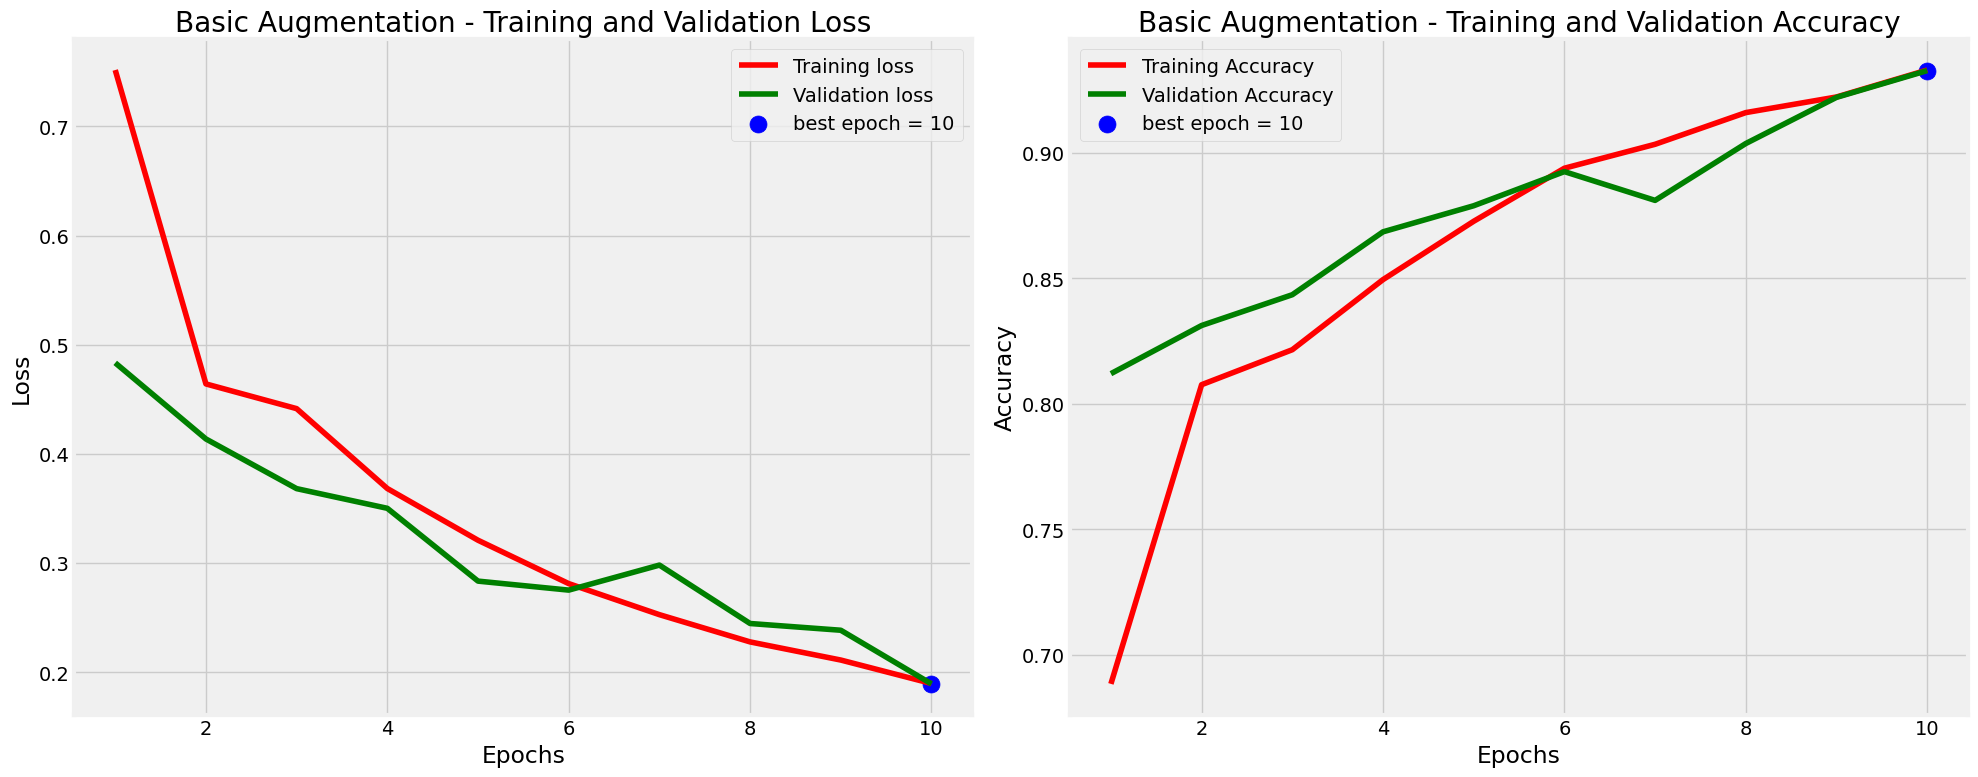

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step


In [ ]:
hist_basic, metrics_basic = train_and_evaluate_model(model_basic, basic_train_gen, basic_valid_gen, basic_test_gen, 'Basic', epochs=10)

469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step


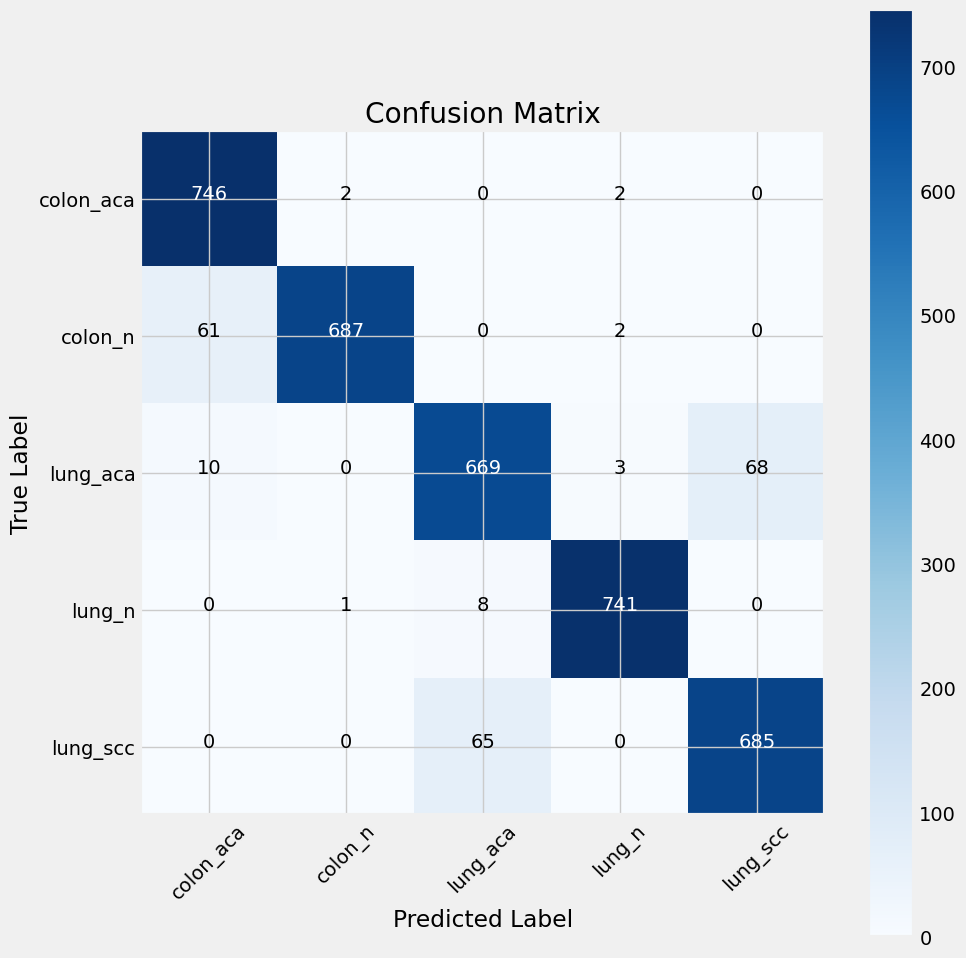

In [ ]:
y_predict_basic = model_basic.predict(basic_test_gen)
confusion_matrix_plot(basic_test_gen, y_predict_basic)

### 5.2.2 Training Moderate Augmentation

In [ ]:
model_moderate = create_model()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 128)         │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 32768, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_6 (Lambda)                    │ (None, 32768, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_layer_6 (CapsuleLayer)       │ (None, 16, 8)               │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_layer_7 (CapsuleLayer)       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_7 (Lambda)                    │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 681,664 (2.60 MB)

 Trainable params: 681,664 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 138s 60ms/step - accuracy: 0.5189 - loss: 1.0190 - val_accuracy: 0.7819 - val_loss: 0.5639
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 121s 55ms/step - accuracy: 0.7819 - loss: 0.5389 - val_accuracy: 0.7821 - val_loss: 0.5358
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.8135 - loss: 0.4345 - val_accuracy: 0.8507 - val_loss: 0.4007
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 124s 56ms/step - accuracy: 0.8379 - loss: 0.3868 - val_accuracy: 0.8416 - val_loss: 0.3830
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.8565 - loss: 0.3526 - val_accuracy: 0.8683 - val_loss: 0.3065
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 124s 57ms/step - accuracy: 0.8822 - loss: 0.3049 - val_accuracy: 0.8867 - val_loss: 0.2918
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 126s 58ms/step - accuracy: 0.8956 - loss: 0.2671 - val_accuracy: 0.9120 - val_loss: 0.2322
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 

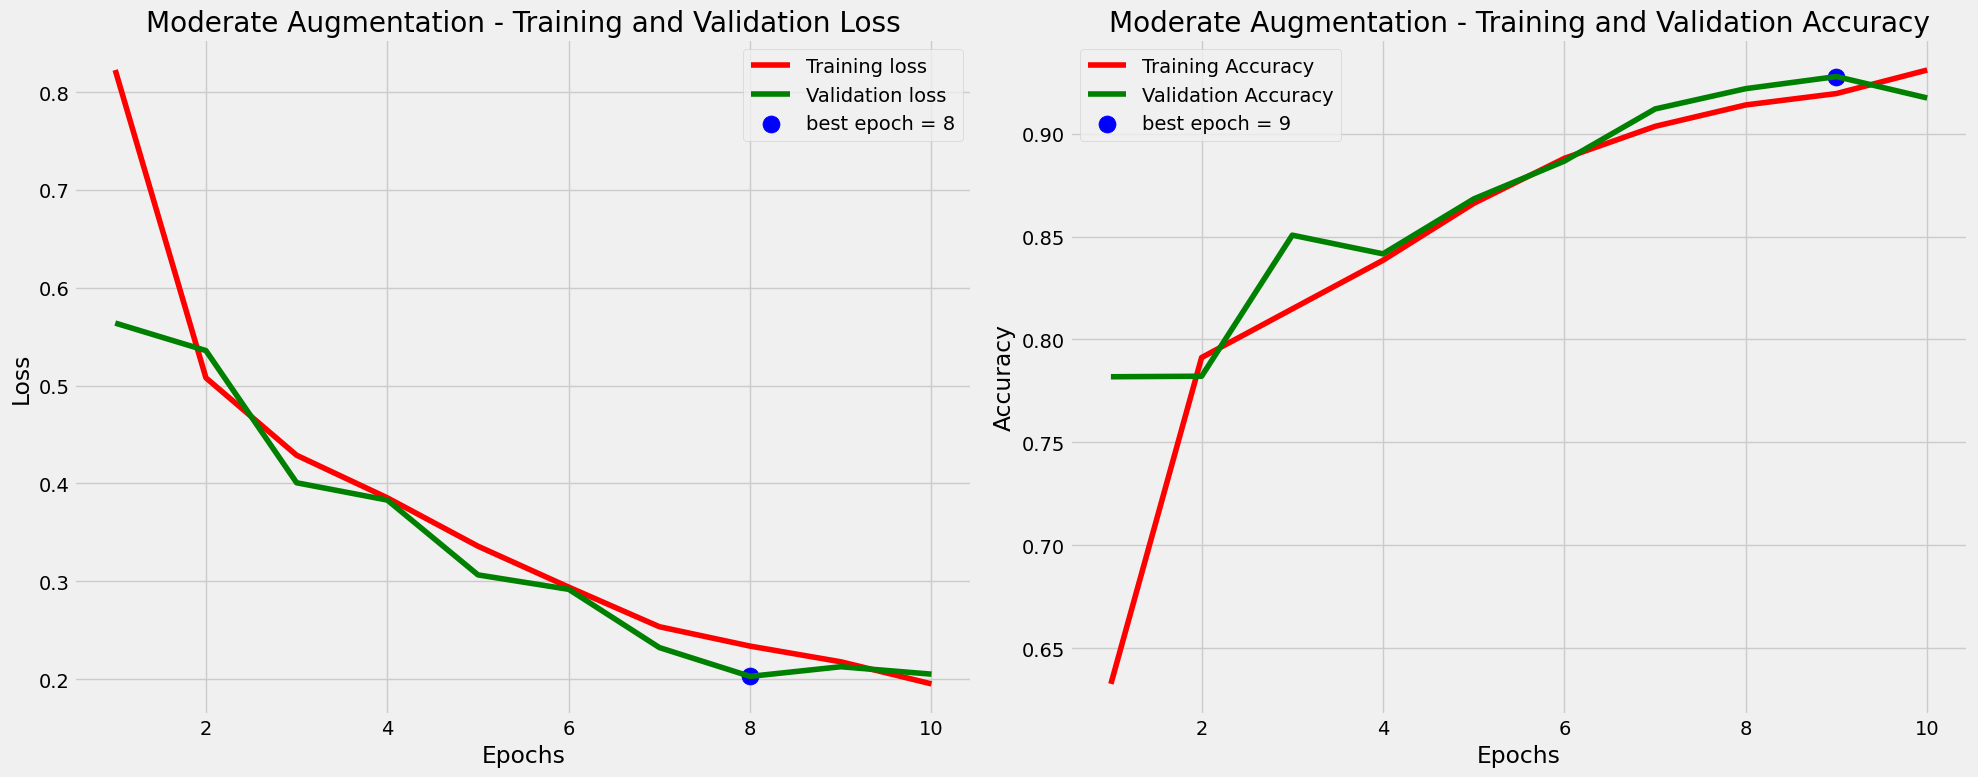

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step


In [ ]:
hist_moderate, metrics_moderate = train_and_evaluate_model(model_moderate, moderate_train_gen, moderate_valid_gen, moderate_test_gen, "Moderate", epochs= 10)

469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step


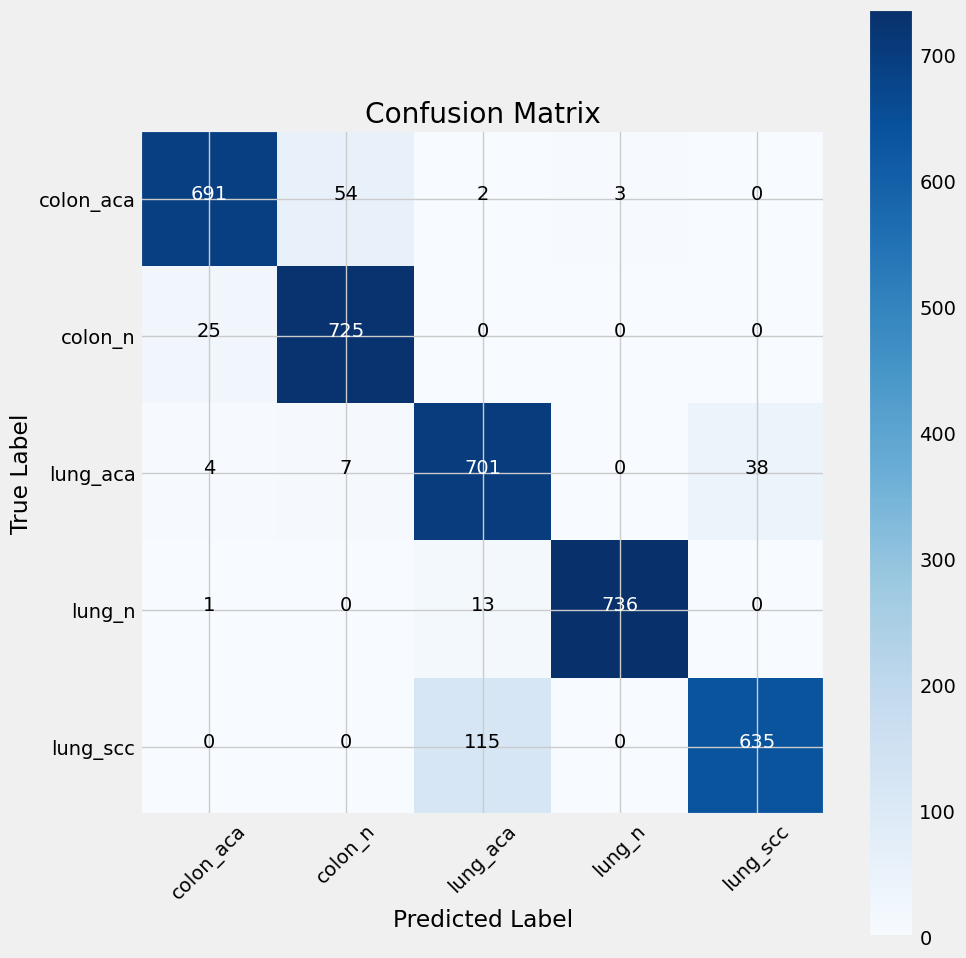

In [ ]:
y_predict_moderate = model_moderate.predict(moderate_test_gen)
confusion_matrix_plot(moderate_test_gen, y_predict_moderate)

### 5.2.3 Training Advanced Augmentation

In [ ]:
model_advanced = create_model()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 128)         │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 32768, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 32768, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_layer_8 (CapsuleLayer)       │ (None, 16, 8)               │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_layer_9 (CapsuleLayer)       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_9 (Lambda)                    │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 681,664 (2.60 MB)

 Trainable params: 681,664 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 140s 61ms/step - accuracy: 0.5811 - loss: 0.9634 - val_accuracy: 0.7677 - val_loss: 0.5809
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.7764 - loss: 0.5608 - val_accuracy: 0.8221 - val_loss: 0.4278
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 121s 55ms/step - accuracy: 0.8189 - loss: 0.4438 - val_accuracy: 0.8349 - val_loss: 0.3921
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 120s 55ms/step - accuracy: 0.8309 - loss: 0.4065 - val_accuracy: 0.8544 - val_loss: 0.3918
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 120s 55ms/step - accuracy: 0.8512 - loss: 0.3696 - val_accuracy: 0.8739 - val_loss: 0.3221
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 120s 55ms/step - accuracy: 0.8697 - loss: 0.3335 - val_accuracy: 0.8915 - val_loss: 0.3025
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 121s 55ms/step - accuracy: 0.8779 - loss: 0.3153 - val_accuracy: 0.8880 - val_loss: 0.2897
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 

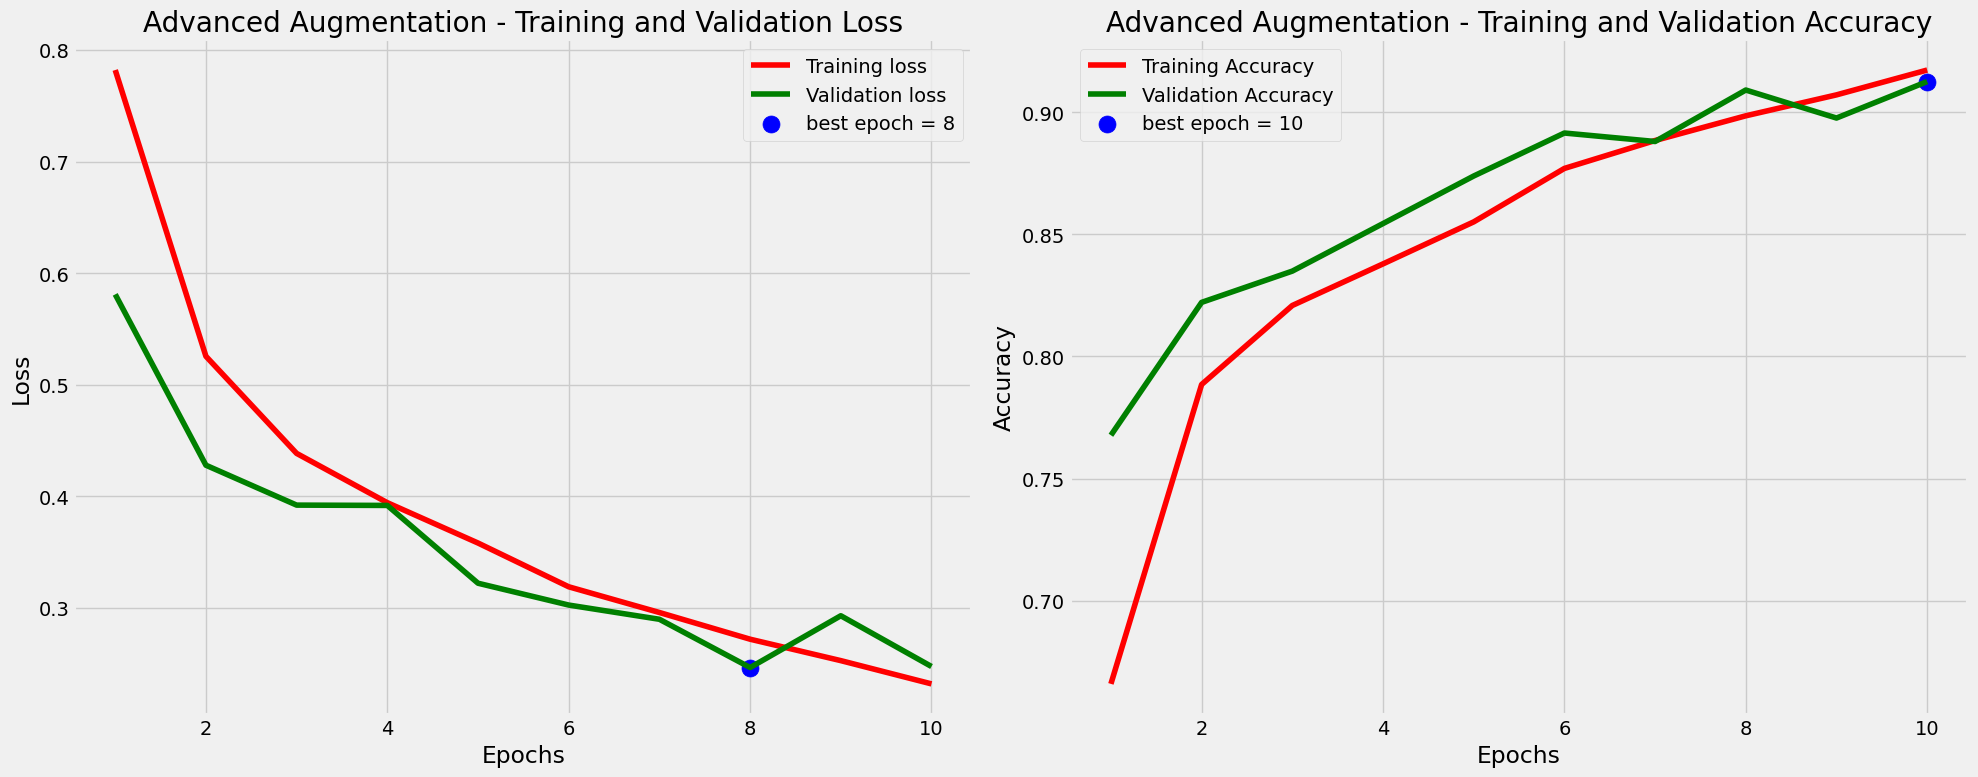

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step


In [ ]:
hist_advanced, metrics_advanced = train_and_evaluate_model(model_advanced, advanced_train_gen, advanced_valid_gen, advanced_test_gen, "Advanced", epochs=10)

469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step


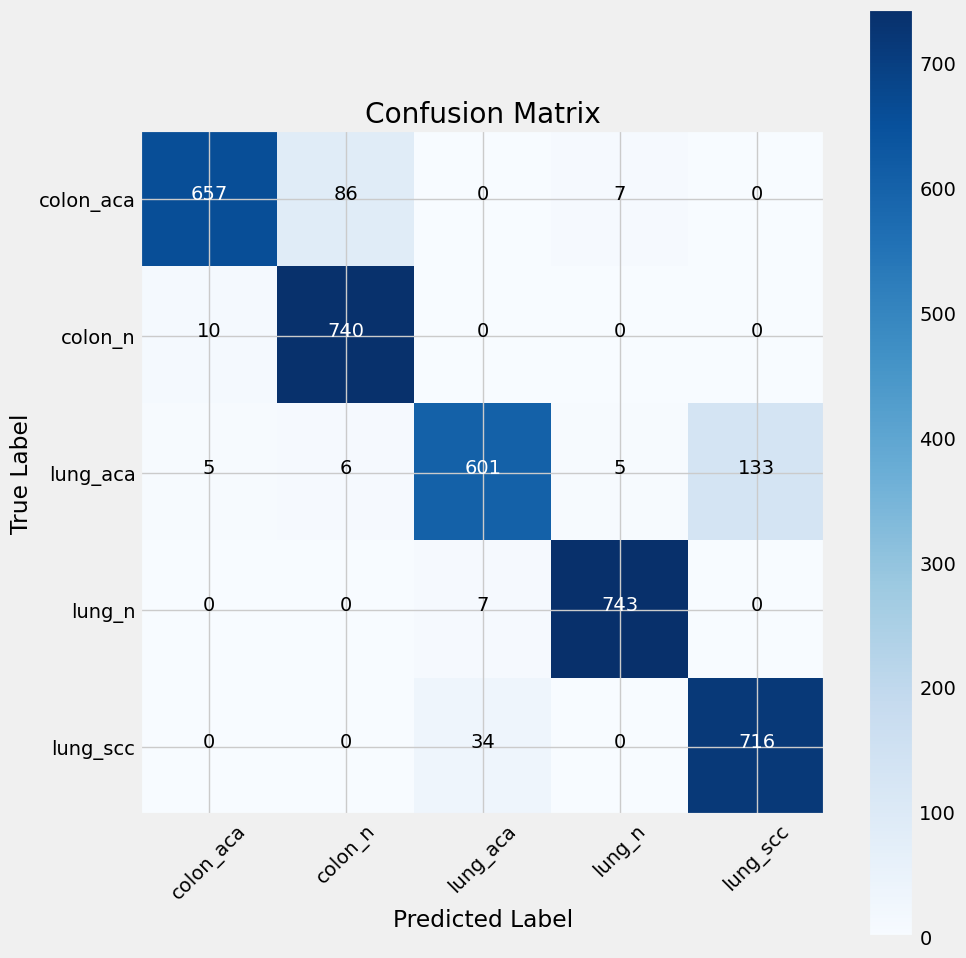

In [ ]:
y_predict_advanced = model_advanced.predict(advanced_test_gen)
confusion_matrix_plot(advanced_test_gen, y_predict_advanced)

# 6. Evaluation

In [ ]:
print(metrics_basic)

{'best_val_loss': 0.18920814990997314, 'best_val_loss_epoch': np.int64(10), 'best_val_acc': 0.9327999949455261, 'best_val_acc_epoch': np.int64(10), 'test_precision': 0.9421404772312328, 'test_recall': 0.9408, 'test_f1': 0.9407833512665194}


In [ ]:
print(metrics_moderate)

{'best_val_loss': 0.20277029275894165, 'best_val_loss_epoch': np.int64(8), 'best_val_acc': 0.9277333617210388, 'best_val_acc_epoch': np.int64(9), 'test_precision': 0.9327643637427133, 'test_recall': 0.9301333333333334, 'test_f1': 0.9302702984769778}


In [ ]:
print(metrics_advanced)

{'best_val_loss': 0.24648354947566986, 'best_val_loss_epoch': np.int64(8), 'best_val_acc': 0.9125333428382874, 'best_val_acc_epoch': np.int64(10), 'test_precision': 0.9261379584327976, 'test_recall': 0.9218666666666666, 'test_f1': 0.9212032344974099}
